In [1]:
import networkx as nx
import math
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import sort
import urllib.request
import io
import zipfile
import numpy as np
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:

# distance dynamics function
def d(G, u, v):
  tu = set(G.neighbors(u)).union(set([u]))
  tv = set(G.neighbors(v)).union(set([v]))

  nr = 0 
  for x in tu.intersection(tv):
    try :
      a = G[u][x]['weight']
    except:
      a = 1
  
    try :
      b = G[v][x]['weight']
    except:
      b = 1 

    nr += (a + b)

  dr = 0
  for x,y in G.edges():
    union = tu.union(tv)
    if x in union and y in union:
      dr += G[x][y]['weight']
  return 1 - (nr / dr)

# exclusive neighbours 
def en(G, u, v):
  tu = set(G.neighbors(u)).union(set([u]))
  tv = set(G.neighbors(v)).union(set([v]))

  return tu - tu.intersection(tv)

# Direct linked nodes
def di(G, u, v):
  a = math.sin(1 - d(G, u, v)) / G.degree(u) 
  b = math.sin(1 - d(G, u, v)) / G.degree(v) 

  return -(a+b)

# common neighbours
def ci(G, u, v):
  sum = 0 
  for x in nx.common_neighbors(G, u, v):
    sum += ((math.sin(1-d(G, x, u))*(1-d(G, x, v)))/G.degree(u)) + ((math.sin(1-d(G, x, v))*(1-d(G, x, u)))/G.degree(v)) 

  return -sum
  
# phi
## phi(x, u) => phi(G, x, v)
## phi(y, v) => phi(G, y, u)
def phi(G, u, v, lam):
  temp = 1-d(G, u, v)
  return temp if temp >= lam else temp-lam

# exclusive neighburs
def ei(G, u, v, lam): 
  a = 0 
  for x in en(G, u, v):
    a += (math.sin(1-d(G, x, u))*phi(G, x, v, lam))
  
  a /= G.degree(u)

  b = 0 
  for y in en(G, v, u):
    b += (math.sin(1-d(G, y, v))*phi(G, y, u, lam))
  
  b /= G.degree(v)

  return -(a+b)


In [3]:
#this is the main attractor function as in algorithm. Here we will call the above declared functions.
def attractor(graph, lam, weighted= True):
  G = nx.Graph(graph)
  m = 1

  if not weighted: #as mentioned in paper, if the grpah is unweighted, we add weights as 1.
    for u, v in G.edges():
      G[u][v]['weight'] = 1

  # initialisation  
  for u, v in G.edges():
    print(m)
    G[u][v]['d'] = d(G, u, v)

    for x in en(G, u ,v):
      G[u][x]['d'] = d(G, u, x)

    for y in en(G, v, u):
      G[v][y]['d'] = d(G, v, y)
    m += 1

  # dynamic interaction 
  flag = True
  n = 1
  while flag:
    flag = False

    for u, v in G.edges():
      print("here ",n)
      if G[u][v]['d'] > 0 and G[u][v]['d'] < 1:
        delta = di(G, u, v) + ci(G, u, v) + ei(G, u, v, lam) 

        if delta != 0 :
          G[u][v]['d'] += delta 

          if G[u][v]['d'] > 1:
            G[u][v]['d'] = 1
          if G[u][v]['d'] < 0:
            G[u][v]['d'] = 0
  
          flag = True
      n +=1

  # find communities
  for u, v in G.edges():
    if G[u][v]['d'] == 1: #as mentioned, if the distance between nodes is 1, we will remove that edge.
      G.remove_edge(u, v)
    
  return G


In [ ]:


#this function is for finding cluster purity in experimental evaluation
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

We are using normalized_mutual_info_score() to calculate NMI , adjusted_rand_score() to calculate Adjuusted Rand Index and purity_score() for Cluster Purity Score which are required and are there in table 2 in research paper.

Number of Communities Detected is 2
Graph named "Zachary's Karate Club" with 34 nodes and 78 edges
Average Degree is  4.588235294117647
Clustering coefficient is  0.5706384782076823
NMI Score  1.0
Cluster Purity Score  1.0
Adjusted Rand Index  1.0


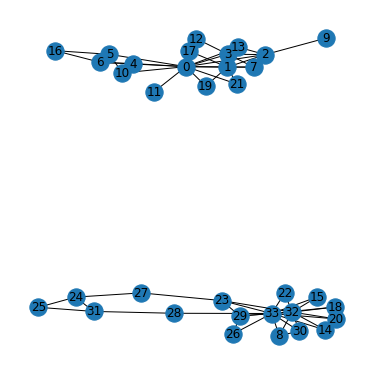

In [ ]:

G = nx.karate_club_graph()

lam_for_karate = 0.51
G_final = attractor(G,lam_for_karate, weighted=False)

print("Number of Communities Detected is",nx.number_connected_components(G_final))
print(G)
a =0 
b= 0

for i in G.nodes():
  a += G.degree[i]

for j in G.nodes():
  b += nx.clustering(G,j)

print("Average Degree is " ,(a/(i+1)))
print("Clustering coefficient is ",(b/(j+1) ))
max = []

for component in nx.connected_components(G_final):
    component = list(component)
    max  = component.append(max)

#below, we are passing the actual community nodes and the predicted community nodes.

print("NMI Score ",normalized_mutual_info_score([0,9,15,16,19,21,23,24,25,26,27,28,29,30,31,32,33],[8,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33]))

print("Cluster Purity Score ",purity_score([0,9,15,16,19,21,23,24,25,26,27,28,29,30,31,32,33],[8,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33]))

print("Adjusted Rand Index ",adjusted_rand_score([0,9,15,16,19,21,23,24,25,26,27,28,29,30,31,32,33],[8,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33]))

nx.connected_components(G_final)

plt.figure(figsize=(5,5))
nx.draw(G_final, with_labels=True)
plt.show()


Below we are finding communities for Football network.

Below instructions are good to know while calculating NMI, ARI and Cluster Purity.
Basically Football Network Nodes are not integers like 1,2,3...
Nodes have names such as 'BrighamYoung', 'FloridaState'....
Since we cant pass strings into the evaluation functions, we are considering the names as integer node values as below.
1 - BrighamYoung
2 - FloridaState
3 - Iowa ....so on

We used the graph at https://www.researchgate.net/publication/331043127_A_decomposition-based_ant_colony_optimization_algorithm_for_the_multi-objective_community_detection/figures?lo=1 to know the original communities and nodes of the football network and used them.

We are using normalized_mutual_info_score() to calculate NMI , adjusted_rand_score() to calculate Adjuusted Rand Index and purity_score() for Cluster Purity Score which are required and are there in table 2 in research paper.





Number of Communities Detected is 12
Graph with 115 nodes and 613 edges
Average Degree is  10.568965517241379
Clustering coefficient is  0.39974001094690764
NMI Score  1.0
Cluster Purity Score  1.0
Adjusted Rand Index  1.0


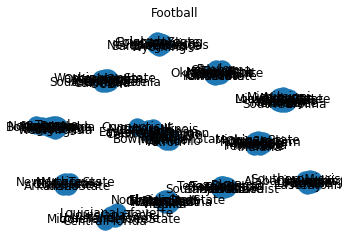

In [ ]:



url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

lam_for_football = 0.4

G_final = attractor(G, lam_for_football, weighted=False)

nx.number_connected_components(G_final)

print("Number of Communities Detected is",nx.number_connected_components(G_final))
print(G)
a =0 
b= 0
n = 0

for i in G.nodes():
  a += G.degree[i]
  n +=1

for j in G.nodes():
  b += nx.clustering(G,j)

print("Average Degree is " ,(a/(n+1)))
print("Clustering coefficient is ",(b/(n+1) ))

max = []

for component in nx.connected_components(G_final):
    component = list(component)

#below, we are passing the actual community nodes and the predicted community nodes.

print("NMI Score ",normalized_mutual_info_score([15,19,27,32,35,39,44,55,62,13,72,100,86,0],[32,27,72,86,13,19,100,43,44,35,55,39,15,62]))

print("Cluster Purity Score ",purity_score([15,19,27,32,35,39,44,55,62,13,72,100,86,0],[32,27,72,86,13,19,100,43,44,35,55,39,15,62]))

print("Adjusted Rand Index ",adjusted_rand_score([15,19,27,32,35,39,44,55,62,13,72,100,86,0],[32,27,72,86,13,19,100,43,44,35,55,39,15,62]))

plt.title("Football")
nx.draw(G_final, with_labels=True)
plt.show()



Below we are finding communities for Polbooks network.

Below instructions are good to know while calculating NMI, ARI and Cluster Purity.
Basically Polbooks Network Nodes are not integers like 1,2,3...
Nodes have names such as 'The Future of Freedom', 'The Bushes'....
Since we cant pass strings into the evaluation functions, we are considering the names as integer node values as below.
1 - The Future of Freedom
2 - The Bushes ...so on

We used the graph at https://www.researchgate.net/publication/331043127_A_decomposition-based_ant_colony_optimization_algorithm_for_the_multi-objective_community_detection/figures?lo=1 to know the original communities and nodes of the football network and used them.

We are using normalized_mutual_info_score() to calculate NMI , adjusted_rand_score() to calculate Adjuusted Rand Index and purity_score() for Cluster Purity Score which are required and are there in table 2 in research paper.





Number of Communities Detected is 3
Graph with 105 nodes and 441 edges
Average Degree is  8.320754716981131
Clustering coefficient is  0.4829274818804887
NMI Score  0.6676426555733436
Cluster Purity Score  0.8604651162790697
Adjusted Rand Index  0.0


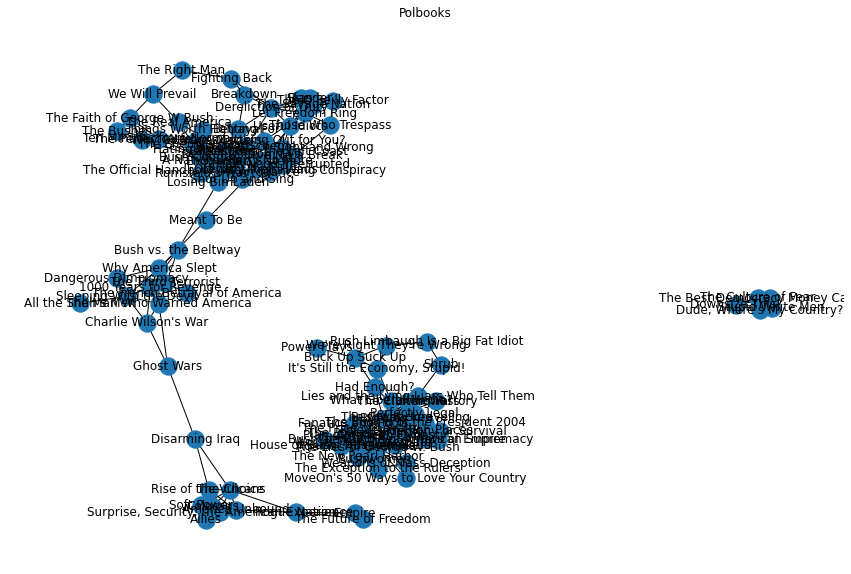

In [ ]:

url = "http://www-personal.umich.edu/~mejn/netdata/polbooks.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("polbooks.txt").decode()  # read info file
gml = zf.read("polbooks.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

lam_for_polbooks = 0.4

G_final = attractor(G, lam_for_polbooks, weighted=False)

nx.number_connected_components(G_final)

print("Number of Communities Detected is",nx.number_connected_components(G_final))
print(G)
a =0 
b= 0
n = 0

for i in G.nodes():
  a += G.degree[i]
  n +=1

for j in G.nodes():
  b += nx.clustering(G,j)


print("Average Degree is " ,(a/(n+1)))
print("Clustering coefficient is ",(b/(n+1) ))
#below, we are passing the actual community nodes and the predicted community nodes.

print("NMI Score ",normalized_mutual_info_score([1,5,29,104,47,7,77,70,105,19,49,8,52],[63,60,61,100,64,0,0,0,0,0,0,0,0]))

print("Cluster Purity Score ",purity_score([31,32,60,61,62,63,64,65,66,67,68,69,71,72,73,74,75,76,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103],[31,32,47,62,67,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,101,102,103,0,0,0,0,0,0,0]))

print("Adjusted Rand Index ",adjusted_rand_score([1,5,29,104,47,7,77,70,105,19,49,8,52],[63,60,61,100,64,0,0,0,0,0,0,0,0]))

for component in nx.connected_components(G_final):
    component = list(component)
    

  
plt.figure(figsize=(15,10))
plt.title("Polbooks")
nx.draw(G_final, with_labels=True)
plt.show()

Below is the Collaboration Network which is network without class.
This network contains 26k edges and was taking a lot of time to execute. So only, there is no output for this network yet. 

In [ ]:
# Without Class Nework - Collaboration Network (New Additional network)

url = "http://www-personal.umich.edu/~mejn/netdata/hep-th.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("hep-th.txt").decode()  # read info file
gml = zf.read("hep-th.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

lam_for_col = 0.4

G_final = attractor(G, lam_for_col, weighted=False)

nx.number_connected_components(G_final)

print("Number of Communities Detected is",nx.number_connected_components(G_final))
print(G)
a =0 
b= 0
n = 0

for i in G.nodes():
  a += G.degree[i]
  n +=1

for j in G.nodes():
  b += nx.clustering(G,j)


print("Average Degree is " ,(a/(n+1)))
print("Clustering coefficient is ",(b/(n+1) ))

for component in nx.connected_components(G_final):
    component = list(component)
    

  
plt.figure(figsize=(15,10))
plt.title("Collaboration")
nx.draw(G_final)